# Parsing Kinase Data into a Required Format

In [6]:
import re
import copy
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Files to consider:

In [2]:
file_active      = 'data/kinome_assay_LINCS_kinomescan_active.csv'
file_w_active    = 'data/kinome_assay_LINCS_kinomescan_weak_active.csv'
file_inactive    = 'data/kinome_assay_LINCS_kinomescan_inactive.csv'
file_w_inactive  = 'data/kinome_assay_LINCS_kinomescan_weak_inactive.csv'

In [3]:
col_names=["compound_name", "target", "activity_measure"]
active_rel         = pd.read_csv(file_active,names=col_names)
weak_active_rel    = pd.read_csv(file_w_active,names=col_names)
inactive_rel       = pd.read_csv(file_inactive,names=col_names)
weak_inactive_rel  = pd.read_csv(file_w_inactive,names=col_names)

### Number of relations of each of 4 types:

In [4]:
len(active_rel)

15319

In [5]:
len(weak_active_rel)

32153

In [6]:
len(inactive_rel)

443682

In [7]:
len(weak_inactive_rel)

59798

### Structure of the files:

In [8]:
active_rel.head()

,compound_name,target,activity_measure
0,KTMLCPCWNLTDRL-UHFFFAOYSA-N,P42338,10.0
1,KTMLCPCWNLTDRL-UHFFFAOYSA-N,Q8NEB9,10.0
2,LIGGMBSSOOVGAE-UHFFFAOYSA-N,P00519,8.521574020385742
3,LIGGMBSSOOVGAE-UHFFFAOYSA-N,P07333,8.999565124511719
4,LIGGMBSSOOVGAE-UHFFFAOYSA-N,Q9UPZ9,10.0


Add "activity_class" to merge the dataframes.
<br>
* "activity_class" = 1 if from active_rel or weak_active_rel dataframe
<br>
* "activity_class" = 0 if from inactive_rel or weak_inactive_rel dataframe

In [9]:
active_rel["activity_class"]        = 1
weak_active_rel["activity_class"]   = 1
inactive_rel["activity_class"]      = 0
weak_inactive_rel["activity_class"] = 0

In [10]:
inactive_rel.head()

,compound_name,target,activity_measure,activity_class
0,KTMLCPCWNLTDRL-UHFFFAOYSA-N,Q2M2I8,5.211629390716553,0
1,KTMLCPCWNLTDRL-UHFFFAOYSA-N,P00519,5.589825630187988,0
2,KTMLCPCWNLTDRL-UHFFFAOYSA-N,P00519(phosphorylated),5.397940158843994,0
3,KTMLCPCWNLTDRL-UHFFFAOYSA-N,P42684,4.721246242523193,0
4,KTMLCPCWNLTDRL-UHFFFAOYSA-N,P37023,4.995201110839844,0


## Merge the Dataframes

In [11]:
frames = [active_rel, weak_active_rel, inactive_rel, weak_inactive_rel]
all_relations = pd.concat(frames)

In [12]:
all_relations[16:20]

,compound_name,target,activity_measure,activity_class
16,FFWQODHBPXQXIZ-UHFFFAOYSA-N,Q9Y616,10.0,1
17,IXTOXNKKHFZYSW-UHFFFAOYSA-N,P00519,10.0,1
18,IXTOXNKKHFZYSW-UHFFFAOYSA-N,P00519(phosphorylated),8.999565124511719,1
19,IXTOXNKKHFZYSW-UHFFFAOYSA-N,P42684,10.0,1


### All files together provide information about 550,952 interactions

In [13]:
len(all_relations)

550952

### There are 609 unique targets (we don't include mutations of kinases)

In [14]:
unique_targets = list(set(all_relations["target"].str[0:6]))

In [15]:
all_relations["target"] = all_relations["target"].str[0:6]

In [16]:
len(unique_targets)

609

In [17]:
target_list_size = len(unique_targets)

### Check how many times activity measure about each target is provided that is how many records of interactions between kinase and some chemical compound we have.

In [18]:
targets_frequency = all_relations.target.value_counts()

In [19]:
len(targets_frequency)

609

## We choose only kinases with more than 100 interaction datapoints for the classification challenge

In [20]:
targets_freq_more_than_100 = targets_frequency[targets_frequency > 100]

In [21]:
targets_num = len(targets_freq_more_than_100) 

In [22]:
len(targets_freq_more_than_100) 

420

In [23]:
targets_freq_more_than_1700 = targets_frequency[targets_frequency > 1700]

In [24]:
len(targets_freq_more_than_1700)

125

In [25]:
chosen_targets = list(targets_freq_more_than_100.index)

## Histogram with only top 125 kinases are shown for readibility

Text(0.5, 1.0, 'Frequency of recorded interactions for top 125 kinases')

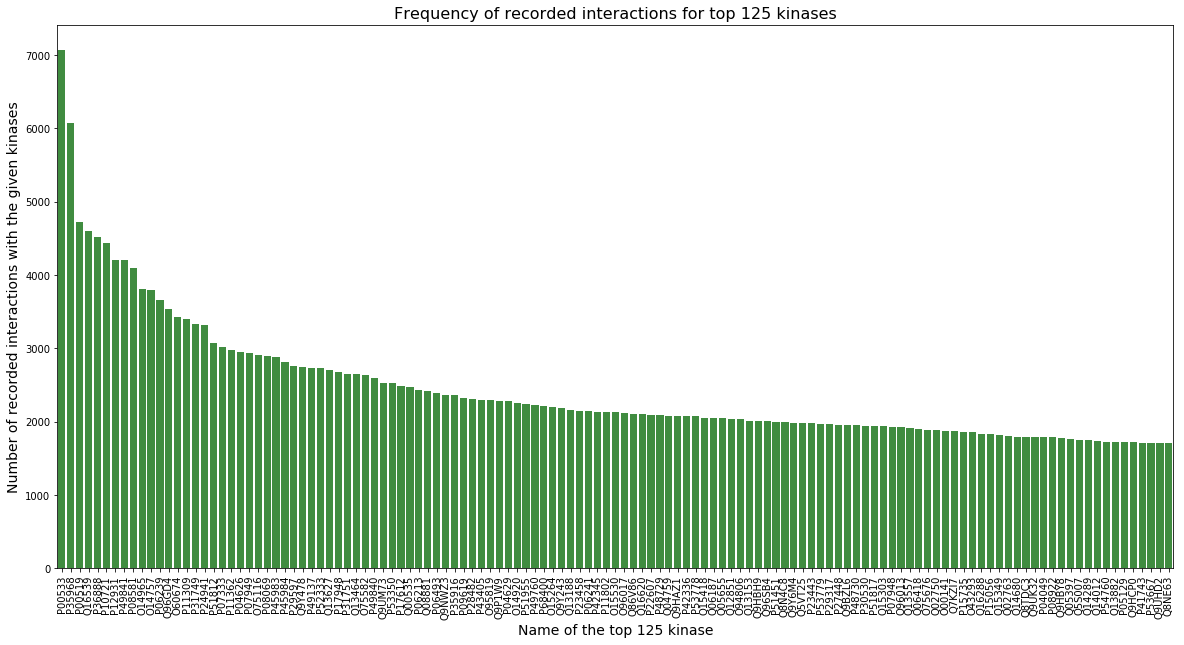

In [26]:
plt.figure(figsize=(20,10))
sns.barplot(targets_freq_more_than_1700.index, targets_freq_more_than_1700.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Name of the top 125 kinase', fontsize=14)
plt.ylabel('Number of recorded interactions with the given kinases', fontsize=14)
plt.title("Frequency of recorded interactions for top 125 kinases",fontsize=16)

## Frequency of recorded kinase interactions per drug

In [27]:
drug_frequency = all_relations.compound_name.value_counts()

In [28]:
drug_frequency_more_than_1 = drug_frequency[drug_frequency  > 5]

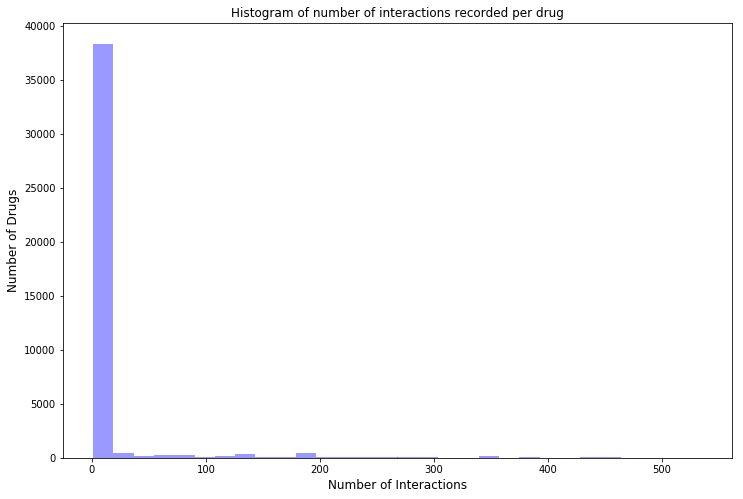

In [29]:
plt.figure(figsize=(12,8))
sns.distplot(drug_frequency.values, bins=30, kde=False, color="blue")
plt.title("Histogram of number of interactions recorded per drug")
plt.xlabel('Number of Interactions', fontsize=12)
plt.ylabel('Number of Drugs', fontsize=12)
plt.show()

In [30]:
drug_frequency_1 = drug_frequency[drug_frequency  <= 1]

In [31]:
len(drug_frequency_1 )

26725

### Comments: over 26,000 chemical compounds have only one recorded target

## Frequency of recorded kinase interactions per drug (consider only drugs with more than 5 interactions)

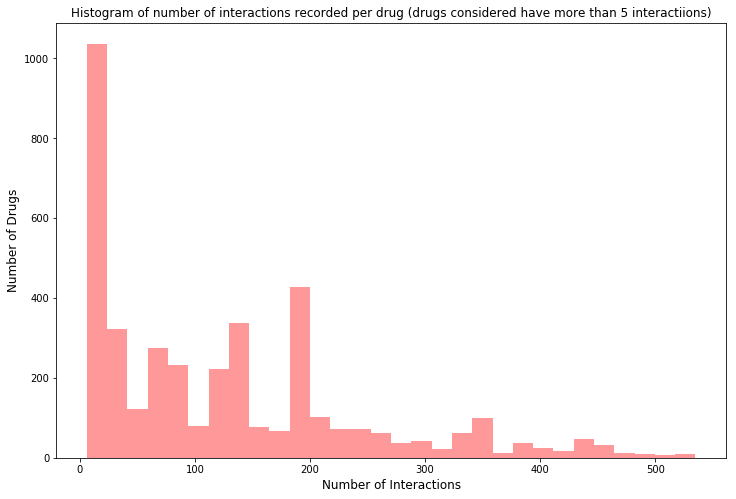

In [32]:
plt.figure(figsize=(12,8))
sns.distplot(drug_frequency_more_than_1.values, bins=30, kde=False, color="red")
plt.title("Histogram of number of interactions recorded per drug (drugs considered have more than 5 interactiions)")
plt.xlabel('Number of Interactions', fontsize=12)
plt.ylabel('Number of Drugs', fontsize=12)
plt.show()

## Save order of kinases in the list for reference:

In [33]:
with open('targets_names.txt', 'w') as f:
    for i in chosen_targets:
        f.write(i)
        f.write('\n')

## Create a dictionary of all the unique compounds (there are 41,464) in the dataset and record all of their interactions with the 420 chosen kinases.
* If `activity class` is 1 mark is as 1
* If `activity class` is 0 mark it as -1

In [34]:
unique_drugs = list(set(all_relations["compound_name"]))
len(unique_drugs)

41464

In [35]:
drugs_targets_dict = {}
for i in range(len(unique_drugs)):
    drugs_targets_dict[unique_drugs[i]] = [0] * targets_num 

In [36]:
targets_dict = {}
for i in range(len(chosen_targets)):
    targets_dict[chosen_targets[i]] = i

In [37]:
for i in range(len(all_relations)):
    kinase_name  = all_relations["target"].values[i]
    kinase_name  = kinase_name[0:6]
    if kinase_name in chosen_targets:
        kinase_index = targets_dict[kinase_name]
        drug_name    = all_relations["compound_name"].values[i]
        if all_relations["activity_class"].values[i] == 1:
            drugs_targets_dict[drug_name][kinase_index] = 1
        else:
            drugs_targets_dict[drug_name][kinase_index] = -1

## Consider how many interactions records we have for each of the drugs

In [38]:
num_interaction_per_drug = {}
for i in range(len(unique_drugs)):
    num_interaction_per_drug[unique_drugs[i]] = 0

In [39]:
for i in range(len(unique_drugs)):
    recorded_interactions = drugs_targets_dict[unique_drugs[i]]
    num_interaction_per_drug[unique_drugs[i]] = np.count_nonzero(recorded_interactions)

## Copy the drugs_targets_dict to create weight vectors

In [40]:
drugs_targets_weights = copy.deepcopy(drugs_targets_dict)

If we have information about the interaction between chemical compound and a given kinases we set weight to 1, otherwise we set the weight to 0.

In [41]:
for i in range(len(unique_drugs)):
    for j in range(len(drugs_targets_weights[unique_drugs[i]])):
        if drugs_targets_weights[unique_drugs[i]][j] != 0:
            drugs_targets_weights[unique_drugs[i]][j] =1

We change in drugs_targets_dict values -1 to 0 since we really mean inactivity.

In [42]:
for i in range(len(unique_drugs)):
    for j in range(len(drugs_targets_dict[unique_drugs[i]])):
        if drugs_targets_dict[unique_drugs[i]][j] == -1:
            drugs_targets_dict[unique_drugs[i]][j] = 0

# Save targets and weights in the files

In [43]:
with open('drug_weights.txt', 'w') as f:
    for key, value in drugs_targets_weights.items():
        f.write(key)
        f.write(',')
        for i in range(len(value)):
            f.write(str(value[i]))
            f.write(",")
        f.write('\n')

In [44]:
with open('drug_targets.txt', 'w') as f:
    for key, value in drugs_targets_dict.items():
        f.write(key)
        f.write(',')
        for i in range(len(value)):
            f.write(str(value[i]))
            f.write(",")
        f.write('\n')

## Save drug names order

In [45]:
with open('drugs_names.txt', 'w') as f:
    for i in unique_drugs:
        f.write(i)
        f.write('\n')

# Find fingerprints for all of the chemical compounds on Venus
`get_fingerprint.py` script

### Files with fingerprints

In [99]:
fingerprints_fh_1    = 'data/fingerprints_1.txt'
fingerprints_fh_2    = 'data/fingerprints_2.txt'

In [100]:
drugs_fingerprints_dict = {}
for i in range(len(unique_drugs)):
    drugs_fingerprints_dict[unique_drugs[i]] = [0] * 1024

In [101]:
def get_fingerprints(file_handle,drugs_fingerprints_dict, drugs_list,drugs_found):
    with open(file_handle) as fh:
        j=0
        content = fh.readlines()
        content = [x.strip() for x in content]
        for line in content:
            result = re.split(r'[,\t]\s*',line)
            drug_name = result[0]
            if drug_name in drugs_list:
                j=j+1
                drugs_found.append(drug_name)
                for i in range(1,1025):
                    drugs_fingerprints_dict[drug_name][i-1] = result[i]
    fh.close()
    print(j)

In [102]:
drugs_found = list()

In [103]:
get_fingerprints(fingerprints_fh_1,drugs_fingerprints_dict ,unique_drugs, drugs_found)

21427


In [104]:
get_fingerprints(fingerprints_fh_2,drugs_fingerprints_dict ,unique_drugs,drugs_found)

20037


In [105]:
len(unique_drugs)

41464

## Print fingerprints to a file:

In [114]:
with open('drug_fingerprints.txt', 'w') as f:
    for key, value in drugs_fingerprints_dict.items():
        f.write(key)
        f.write(',')
        for i in range(len(value)):
            f.write(str(value[i]))
            f.write(",")
        f.write('\n')

# PART 2: Splitting data into train, dev and test set:

In [3]:
file_train  = 'data_splits/kinome_assay_LINCS_kinomescan_round1_train.tsv'
file_test   = 'data_splits/kinome_assay_LINCS_kinomescan_round1_test.tsv'
file_dev    = 'data_splits/kinome_assay_LINCS_kinomescan_round1_dev.tsv'

In [21]:
col_names=["compound_name", "target", "activity_measure"]
train_set     = pd.read_csv(file_train, sep='\t',names=col_names)
test_set       = pd.read_csv(file_test, sep='\t',names=col_names)
dev_set        = pd.read_csv(file_dev, sep='\t',names=col_names)

## TRAIN

In [22]:
train_set.head()

,compound_name,target,activity_measure
0,LIGGMBSSOOVGAE-UHFFFAOYSA-N,P00519-nonphosphorylated,8.521574
1,LIGGMBSSOOVGAE-UHFFFAOYSA-N,P07333,8.999565
2,LIGGMBSSOOVGAE-UHFFFAOYSA-N,Q9UPZ9,10.000000
3,LIGGMBSSOOVGAE-UHFFFAOYSA-N,P10721,10.000000
4,LIGGMBSSOOVGAE-UHFFFAOYSA-N,Q13163,8.698100


In [23]:
train_drugs_set = set(train_set["compound_name"])
test_drugs_set = set(test_set["compound_name"])
dev_drugs_set = set(dev_set["compound_name"])

In [24]:
len(train_drugs_set)

37773

In [25]:
len(test_drugs_set)

101

In [26]:
len(dev_drugs_set)

118

### Check if any of the drugs belongs to more than one set:

In [36]:
train_drugs_set & test_drugs_set

set()

In [37]:
train_drugs_set & dev_drugs_set

set()

In [35]:
len( dev_drugs_set & test_drugs_set )

92

Dev and Test Set have 92 drugs in common.

### Change sets into lists

In [38]:
train_drugs_list = list(train_drugs_set)
test_drugs_list  = list(test_drugs_set) 
dev_drugs_list   = list(dev_drugs_set) 

### Make dictionaries for all of the sets

In [43]:
train_targets_dict = {}
test_targets_dict  = {}
dev_targets_dict   = {}

train_weights_dict = {}
test_weights_dict  = {}
dev_weights_dict   = {}

train_fingerprints_dict = {}
test_fingerprints_dict  = {}
dev_fingerprints_dict   = {}

In [40]:
drugs_targets      = 'drug_targets.txt'
drugs_weights      = 'drug_weights.txt'
drugs_fingerprints = 'drug_fingerprints.txt'

In [41]:
def fill_in_dictionary(dict_name, key_list, vec_size):
    for i in range(len(key_list)):
        dict_name[key_list[i]] = [0] * vec_size

In [42]:
target_size = 420
weight_size = 420
fingerprint_size = 1024

In [48]:
#Everything for train set
fill_in_dictionary(train_targets_dict,train_drugs_list,target_size)
fill_in_dictionary(train_weights_dict, train_drugs_list, weight_size)
fill_in_dictionary(train_fingerprints_dict, train_drugs_list, fingerprint_size)

#Everything for test set
fill_in_dictionary(test_targets_dict, test_drugs_list, target_size)
fill_in_dictionary(test_weights_dict, test_drugs_list, weight_size)
fill_in_dictionary(test_fingerprints_dict, test_drugs_list, fingerprint_size)

#Everything for dev set
fill_in_dictionary(dev_targets_dict, dev_drugs_list, target_size)
fill_in_dictionary(dev_weights_dict, dev_drugs_list, weight_size)
fill_in_dictionary(dev_fingerprints_dict, dev_drugs_list, fingerprint_size)

In [47]:
def get_data_into_dict(file_handle,drugs_fingerprints_dict, drugs_list,vec_size):
    with open(file_handle) as fh:
        j=0
        content = fh.readlines()
        content = [x.strip() for x in content]
        for line in content:
            result = re.split(r'[,\t]\s*',line)
            drug_name = result[0]
            if drug_name in drugs_list:
                j=j+1
                for i in range(1,vec_size+1):
                    drugs_fingerprints_dict[drug_name][i-1] = result[i]
    fh.close()
    print(j)

In [49]:
get_data_into_dict(drugs_targets,train_targets_dict,train_drugs_list,target_size)
get_data_into_dict(drugs_weights,train_weights_dict,train_drugs_list,weight_size)
get_data_into_dict(drugs_fingerprints,train_fingerprints_dict,train_drugs_list,fingerprint_size)

get_data_into_dict(drugs_targets,test_targets_dict,test_drugs_list,target_size)
get_data_into_dict(drugs_weights,test_weights_dict,test_drugs_list,weight_size)
get_data_into_dict(drugs_fingerprints,test_fingerprints_dict,test_drugs_list,fingerprint_size)

get_data_into_dict(drugs_targets,dev_targets_dict,dev_drugs_list,target_size)
get_data_into_dict(drugs_weights,dev_weights_dict,dev_drugs_list,weight_size)
get_data_into_dict(drugs_fingerprints,dev_fingerprints_dict,dev_drugs_list,fingerprint_size)

37773
37773
37773
101
101
101
118
118
118


In [50]:
def data_into_files(data_dict,file_name):
    with open(file_name, 'w') as f:
        for key, value in data_dict.items():
            f.write(key)
            f.write(',')
            for i in range(len(value)):
                f.write(str(value[i]))
                f.write(",")
            f.write('\n')

In [52]:
dict_collection = [train_targets_dict,test_targets_dict,dev_targets_dict,train_weights_dict,test_weights_dict,dev_weights_dict,train_fingerprints_dict,test_fingerprints_dict,dev_fingerprints_dict]

In [56]:
file_name_collection = ['train/train_targets.csv', 'test/test_targets.csv','dev/dev_targets.csv','train/train_weights.csv','test/test_weights.csv','dev/dev_weights.csv','train/train_fingerprints.csv','test/test_fingerprints.csv','dev/dev_fingerprints.csv']

In [57]:
for i,j in zip(dict_collection, file_name_collection):
    data_into_files(i,j)